# Sensitivity statistics -- cycling over the three GMM models

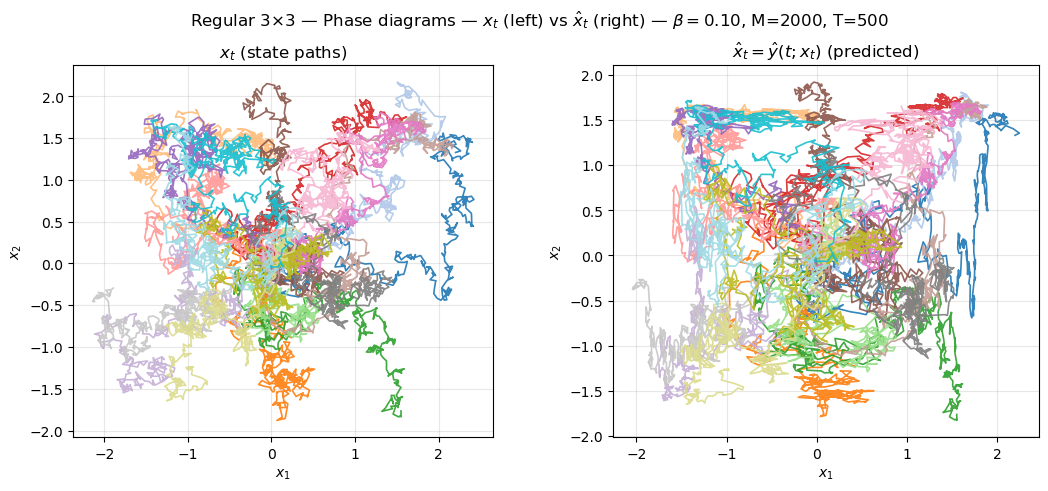

[saved] figs/regular_3x3_phase_diagram_beta0.10_M2000_T500_x0zero.png


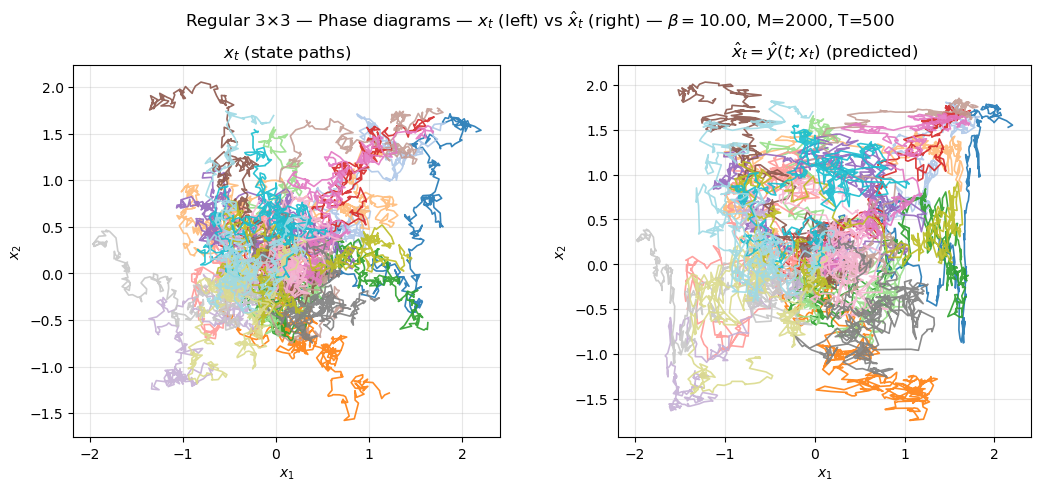

[saved] figs/regular_3x3_phase_diagram_beta10.00_M2000_T500_x0zero.png


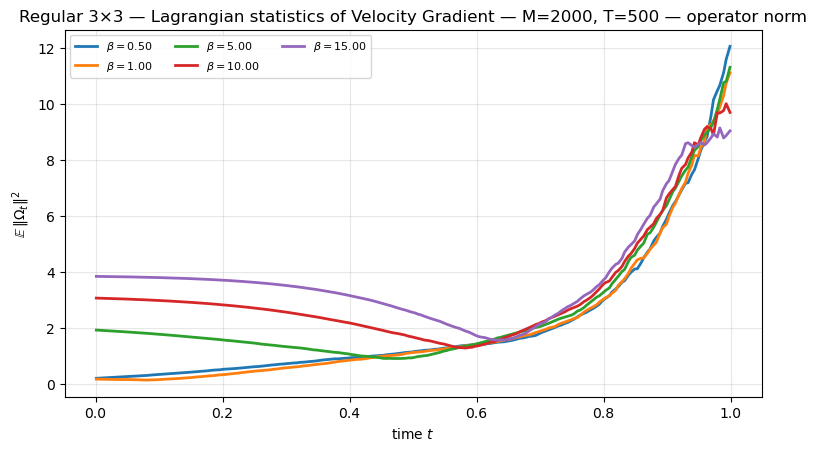

[saved] figs/regular_3x3_omega_stats_M2000_T500_opnorm.png


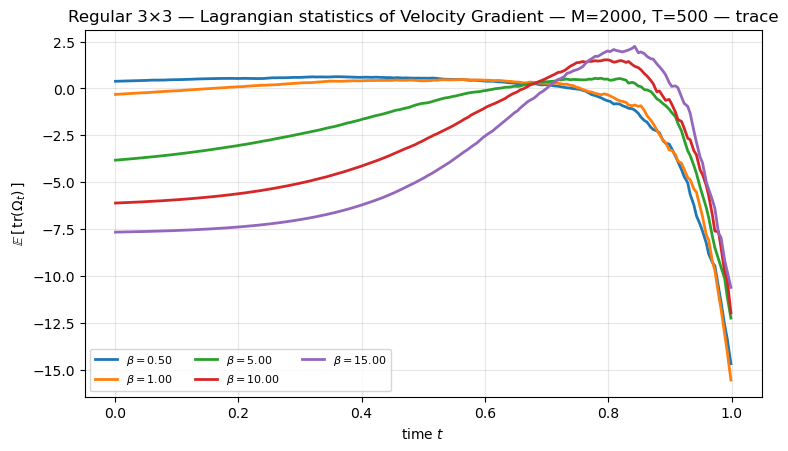

[saved] figs/regular_3x3_omega_stats_M2000_T500_trace.png


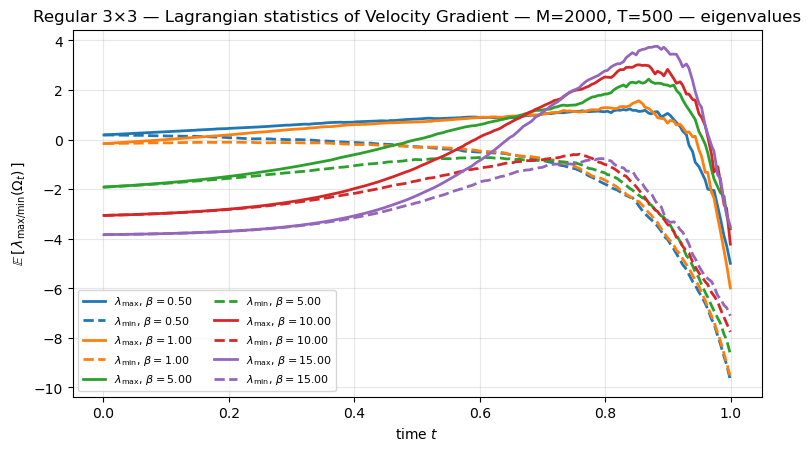

[saved] figs/regular_3x3_omega_stats_M2000_T500_eigs.png


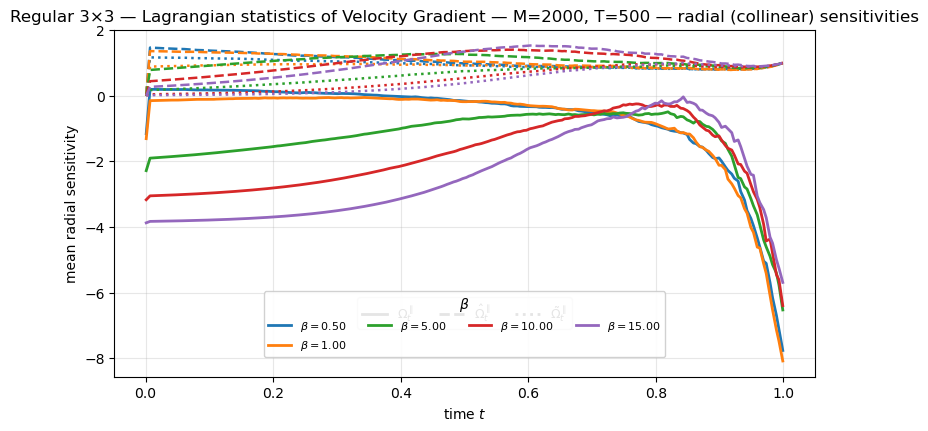

[saved] figs/regular_3x3_omega_stats_M2000_T500_radial_sens.png


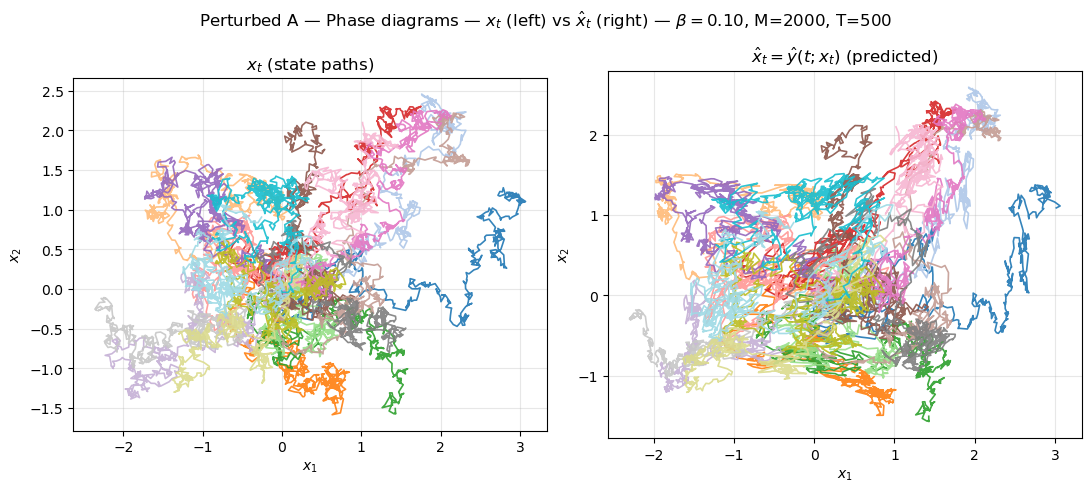

[saved] figs/perturbed_a_phase_diagram_beta0.10_M2000_T500_x0zero.png


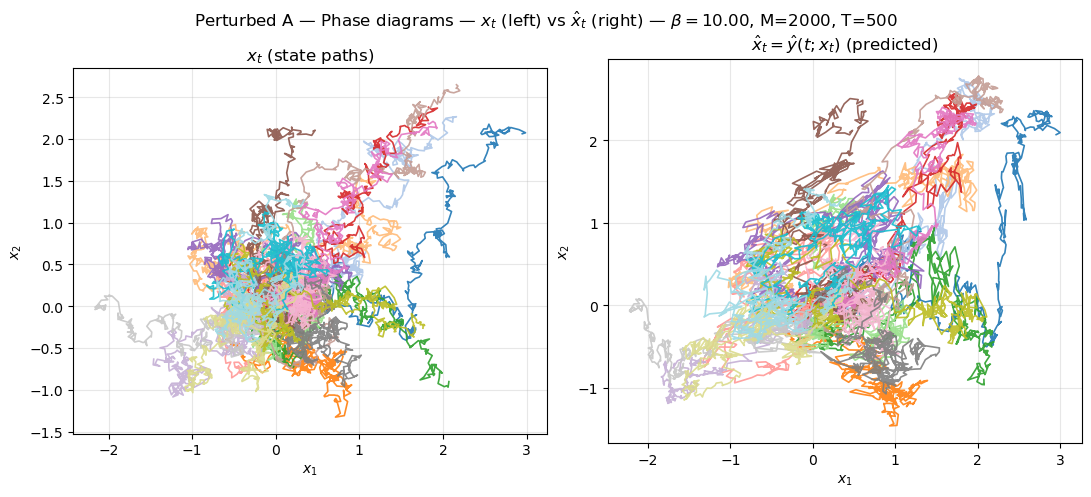

[saved] figs/perturbed_a_phase_diagram_beta10.00_M2000_T500_x0zero.png


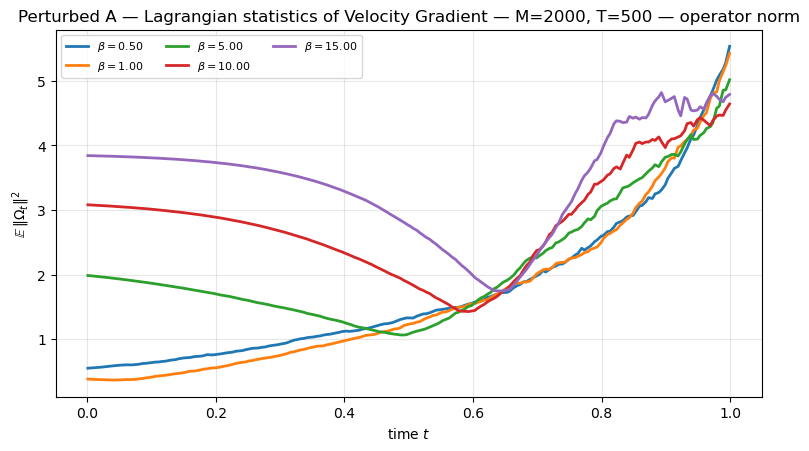

[saved] figs/perturbed_a_omega_stats_M2000_T500_opnorm.png


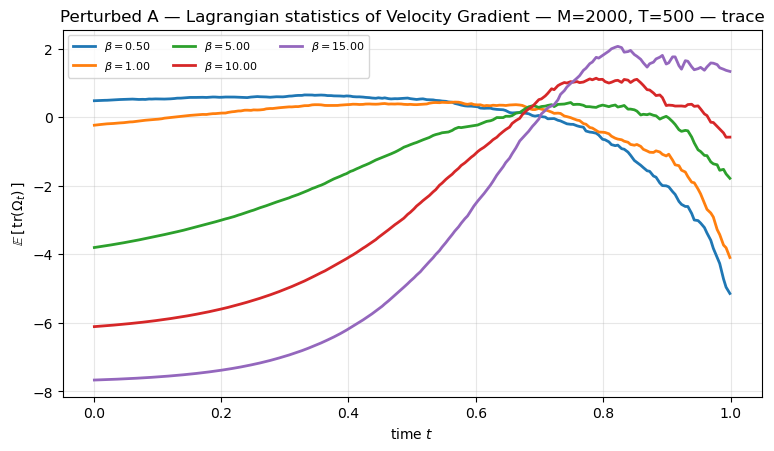

[saved] figs/perturbed_a_omega_stats_M2000_T500_trace.png


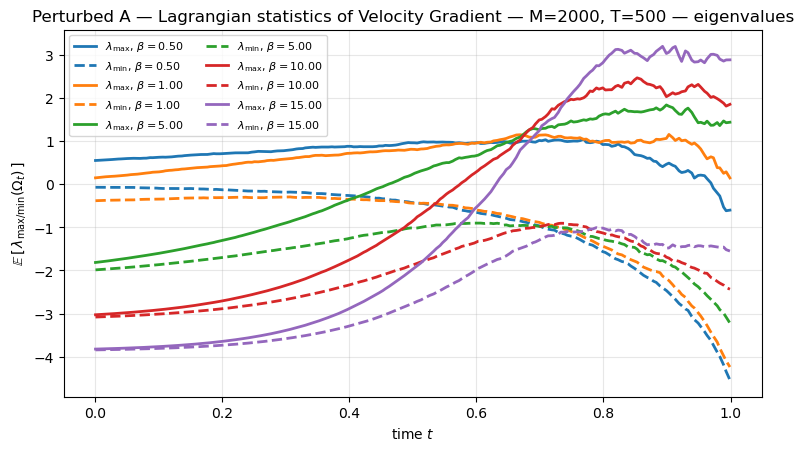

[saved] figs/perturbed_a_omega_stats_M2000_T500_eigs.png


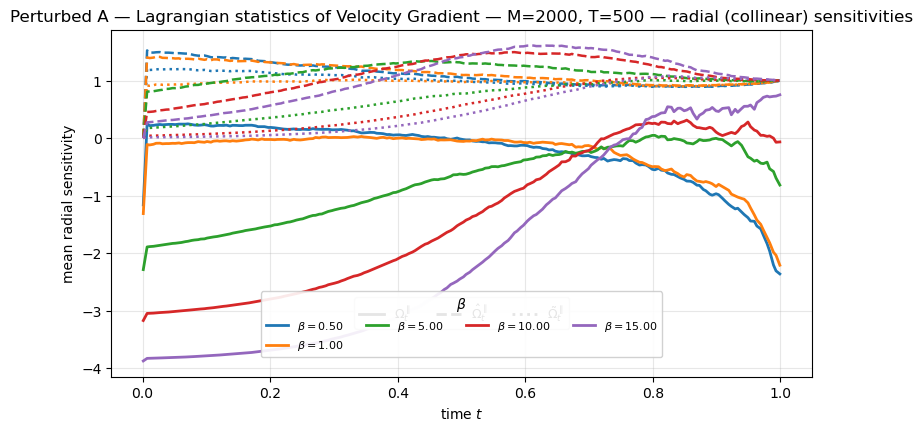

[saved] figs/perturbed_a_omega_stats_M2000_T500_radial_sens.png


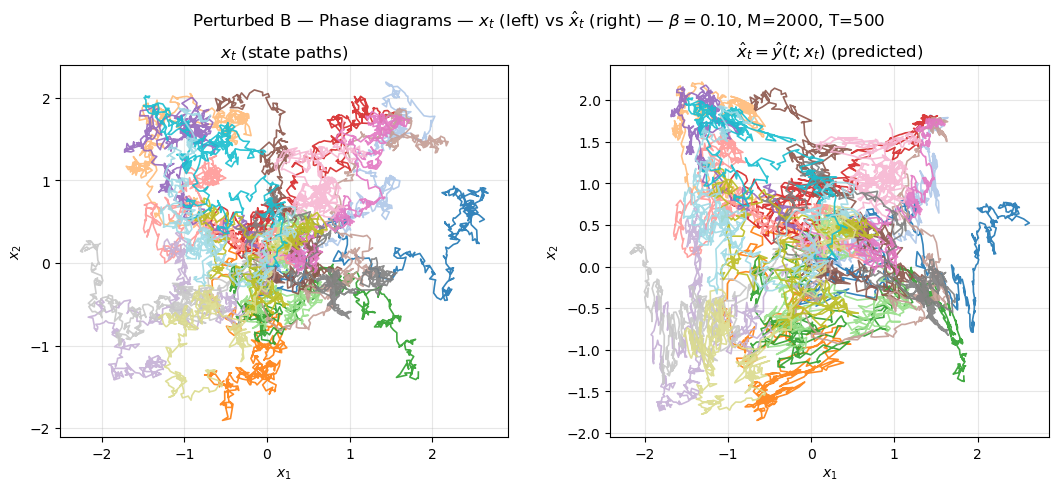

[saved] figs/perturbed_b_phase_diagram_beta0.10_M2000_T500_x0zero.png


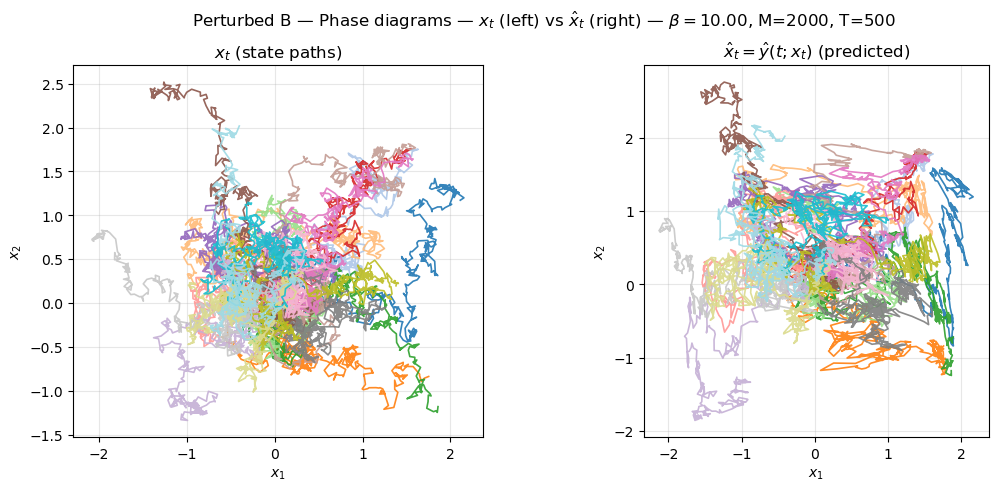

[saved] figs/perturbed_b_phase_diagram_beta10.00_M2000_T500_x0zero.png


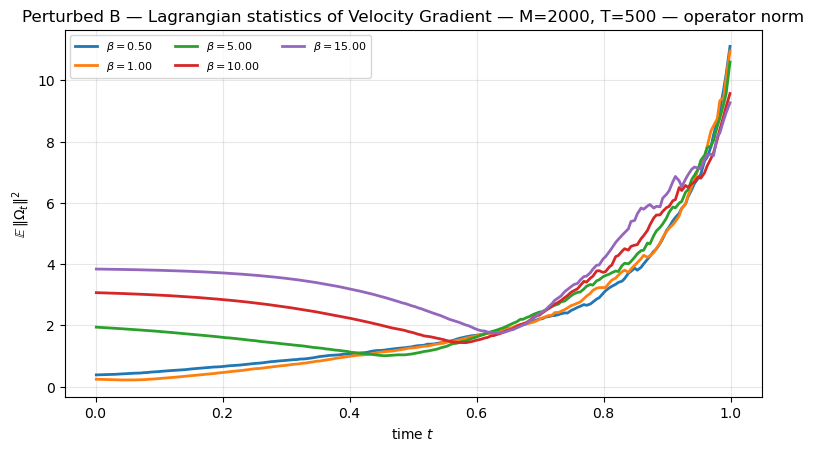

[saved] figs/perturbed_b_omega_stats_M2000_T500_opnorm.png


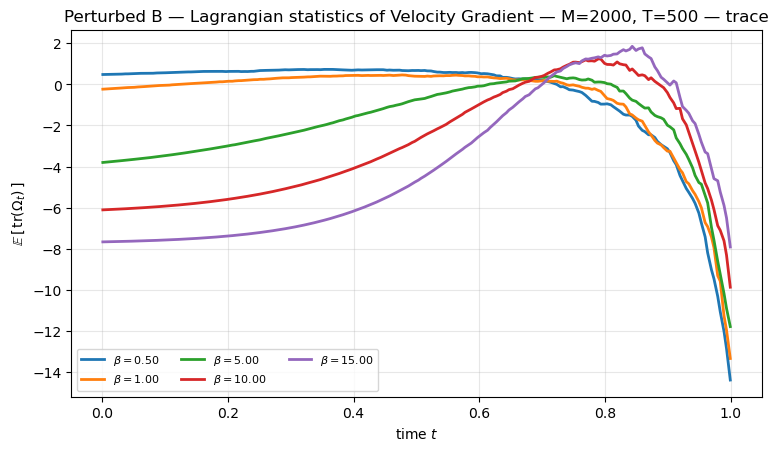

[saved] figs/perturbed_b_omega_stats_M2000_T500_trace.png


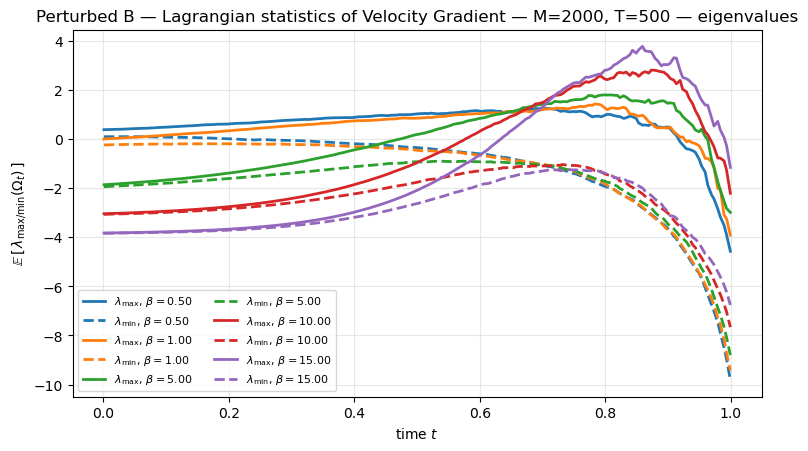

[saved] figs/perturbed_b_omega_stats_M2000_T500_eigs.png


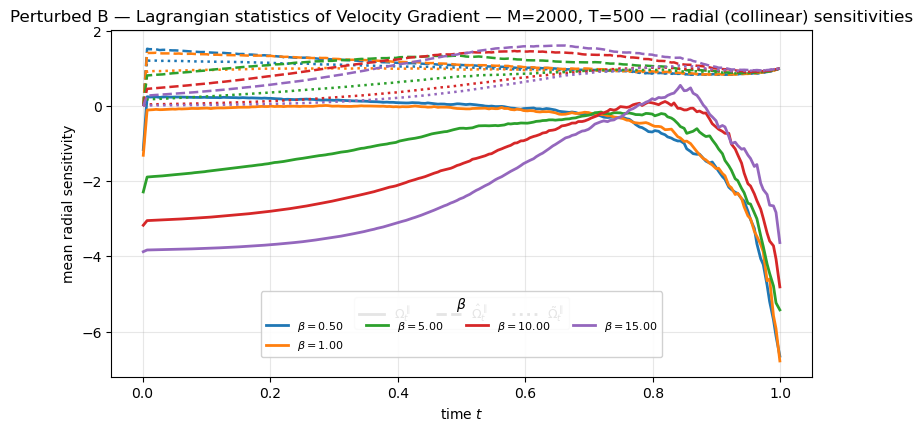

[saved] figs/perturbed_b_omega_stats_M2000_T500_radial_sens.png


In [8]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, regular, pertA, pertB

os.makedirs("figs", exist_ok=True)

# ============================================================
# Phase diagrams (x_t vs ŷ_t) and Ω_t ≡ ∂u*/∂x statistics + radial sensitivities
#   • Phase diagrams: left = x_t paths; right = ŷ_t paths (same colors)
#   • Ω_t stats (central-diff in m = αX), evaluated across ALL interior t ∈ (0,1):
#       - mean operator norm  ||Ω_t||_2
#       - mean trace          tr(Ω_t)
#       - mean eigenvalues    λ_max(Ω_t), λ_min(Ω_t)
#   • Radial (collinear) sensitivities (means over particles):
#       -  Ω_t^{∥}        (control)        = b^- · \hatΩ_t^{∥} − a^-
#       -  \hatΩ_t^{∥}    (predicted map)  = v^T (∂ŷ/∂x) v,  v = x/||x||
#       -  \tildeΩ_t^{∥}  (rescaled map)   = (b^-/a^-) · \hatΩ_t^{∥}
#   • Constant-β schedules (PWC[1]), midpoint drift scheme
#   • This version ENFORCES x(0)=0
# ============================================================

# ---------- central-diff Jacobian ∂ŷ/∂X ----------
def jac_yhat_wrt_X_fd(X, t, sched, gmm, eps_m=None):
    """
    Central-difference Jacobian of ŷ(t;X) w.r.t. X by perturbing measurement m=αX:
        ∂ŷ/∂X ≈ α * [ ŷ(m+ε e_i) - ŷ(m-ε e_i) ] / (2ε)  (column i)
    """
    X = np.asarray(X, float)
    Q, d = X.shape
    alpha, _, gamma = alpha_K_gamma_from_schedule(sched, float(t))
    alpha = float(alpha)
    if not np.isfinite(alpha) or abs(alpha) < 1e-12:
        raise RuntimeError("alpha(t) ill-conditioned at t={}: {}".format(t, alpha))
    if eps_m is None:
        eps_m = 1e-3 * max(float(gamma), 1e-2)

    J  = np.zeros((Q, d, d), float)
    dX = eps_m / alpha

    for i in range(d):
        Xp = X.copy(); Xp[:, i] += dX
        Xm = X.copy(); Xm[:, i] -= dX
        Yp = yhat_oracle_gmm(Xp, float(t), sched, gmm)
        Ym = yhat_oracle_gmm(Xm, float(t), sched, gmm)
        col = (Yp - Ym) / (2.0 * eps_m)   # (Q,d)
        J[:, :, i] = alpha * col          # column i: ∂ŷ/∂X
    return J  # (Q,d,d)

# ---------- Ω_t + radial sensitivities vs time ----------
def omega_stats_vs_time(sched, gmm, M=1200, T=800, seed=1, N_eval=24, Q_stat=400, eps_m=None):
    """
    Simulate once with midpoint EM, starting from X(0)=0.
    At N_eval midpoints spanning the *entire interior* (0,1), compute:
      • matrix stats of Ω_t = b^-·(∂ŷ/∂x) − a^-·I   on a random subset of Q_stat particles
      • radial (collinear) sensitivities means:
          \hatΩ_t^{∥} = v^T (∂ŷ/∂x) v,   v = x/||x||
          \tildeΩ_t^{∥} = (b^-/a^-) · \hatΩ_t^{∥}
          Ω_t^{∥} = b^-·\hatΩ_t^{∥} − a^-
    Returns dict with time grid and per-time means.
    """
    rng = np.random.default_rng(seed)
    dt = 1.0 / T
    d  = gmm.d
    X  = np.zeros((M, d), float)  # ENFORCE x(0)=0

    # choose N_eval evenly-spaced *interior* midpoints across n=0..T-1
    N_eval_eff = int(min(max(1, N_eval), T))
    t_idx = np.unique(np.linspace(0, T-1, N_eval_eff).round().astype(int))
    t_idx = np.clip(t_idx, 0, T-1)
    t_eval = (t_idx + 0.5) / T

    Q_stat = int(min(Q_stat, M))
    sub_idx = rng.choice(M, size=Q_stat, replace=False)

    mean_op   = np.empty(t_eval.size, float)
    mean_tr   = np.empty_like(mean_op)
    mean_lmax = np.empty_like(mean_op)
    mean_lmin = np.empty_like(mean_op)

    mean_Omega_par      = np.empty_like(mean_op)  # Ω_t^{∥}
    mean_Omegahat_par   = np.empty_like(mean_op)  # \hatΩ_t^{∥}
    mean_Omegatilde_par = np.empty_like(mean_op)  # \tildeΩ_t^{∥}

    t_idx_set = set(t_idx.tolist())
    k = 0
    for n in range(T):
        t = (n + 0.5) / T
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X

        if n in t_idx_set:
            X_sub = X[sub_idx, :]
            J = jac_yhat_wrt_X_fd(X_sub, float(t), sched, gmm, eps_m=eps_m)   # (Q,d,d)
            I = np.eye(d)[None, :, :]
            Omega = b_m * J - a_m * I                                        # (Q,d,d)

            evals = np.linalg.eigvalsh(Omega)        # (Q,d)
            opnorm = np.max(np.abs(evals), axis=1)   # ||Ω||_2
            mean_op[k]   = float(np.mean(opnorm))
            mean_tr[k]   = float(np.mean(np.sum(evals, axis=1)))
            mean_lmax[k] = float(np.mean(evals[:, -1]))
            mean_lmin[k] = float(np.mean(evals[:,  0]))

            v = X_sub / (np.linalg.norm(X_sub, axis=1, keepdims=True) + 1e-12)  # (Q,d)
            Jv = np.einsum("qij,qj->qi", J, v)               # (Q,d)
            hat_par = np.einsum("qi,qi->q", Jv, v)           # (Q,)
            if abs(a_m) > 1e-12:
                tilde_par = (b_m / a_m) * hat_par
            else:
                tilde_par = np.full_like(hat_par, np.nan)
            Omega_par = b_m * hat_par - a_m

            mean_Omegahat_par[k]   = float(np.nanmean(hat_par))
            mean_Omegatilde_par[k] = float(np.nanmean(tilde_par))
            mean_Omega_par[k]      = float(np.nanmean(Omega_par))
            k += 1

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return {
        "t_eval": t_eval,
        "mean_op": mean_op, "mean_tr": mean_tr,
        "mean_lmax": mean_lmax, "mean_lmin": mean_lmin,
        "mean_Omega_par": mean_Omega_par,
        "mean_Omegahat_par": mean_Omegahat_par,
        "mean_Omegatilde_par": mean_Omegatilde_par,
    }

# ---------- phase diagrams (x(0)=0) ----------
def simulate_and_collect_for_phase(sched, gmm, M=400, T=600, seed=0, P_show=20):
    rng = np.random.default_rng(seed)
    dt = 1.0 / T
    d  = gmm.d
    X  = np.zeros((M, d), float)  # ENFORCE x(0)=0

    P_show = min(P_show, M)
    idx = rng.choice(M, size=P_show, replace=False)
    X_show  = np.empty((P_show, T, d), float)
    Yh_show = np.empty_like(X_show)

    for n in range(T):
        t = (n + 0.5) / T
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X

        X_show[:, n, :]  = X[idx, :]
        Yh_show[:, n, :] = yhat[idx, :]

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return X_show, Yh_show

def plot_phase_diagram(X_traj, Yh_traj, title, fname):
    P, T, d = X_traj.shape
    assert d == 2, "Phase diagram expects 2D state for plotting."
    cmap = plt.cm.tab20
    cols = [cmap(i % 20) for i in range(P)]

    fig, axs = plt.subplots(1, 2, figsize=(10.8, 4.8), constrained_layout=True)
    for p in range(P):
        axs[0].plot(X_traj[p,:,0],  X_traj[p,:,1],  lw=1.2, alpha=0.9, color=cols[p])
        axs[1].plot(Yh_traj[p,:,0], Yh_traj[p,:,1], lw=1.2, alpha=0.9, color=cols[p])

    for ax, name in zip(axs, ["$x_t$ (state paths)", r"$\hat{x}_t=\hat{y}(t;x_t)$ (predicted)"]):
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, alpha=0.3); ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
        ax.set_title(name)

    fig.suptitle(title)
    fig.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()
    print("[saved] {}".format(fname))

# ---------- plot builders ----------
def plot_omega_summaries(beta_list, summaries, title, fname_prefix):
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    col = {float(b): colors[i % len(colors)] for i,b in enumerate(beta_list)}

    # 1) Operator norm
    plt.figure(figsize=(7.6, 4.4), constrained_layout=True)
    for b in beta_list:
        s = summaries[float(b)]
        plt.plot(s["t_eval"], s["mean_op"], lw=2.0, color=col[float(b)],
                 label=fr"$\beta={float(b):.2f}$")
    plt.xlabel("time $t$"); plt.ylabel(r"$\mathbb{E}\,\|\Omega_t\|^2$")
    plt.title(title + " — operator norm")
    plt.grid(True, alpha=0.3); plt.legend(ncol=3, fontsize=8)
    f1 = f"{fname_prefix}_opnorm.png"
    plt.savefig(f1, dpi=300, bbox_inches="tight"); plt.show(); print(f"[saved] {f1}")

    # 2) Trace
    plt.figure(figsize=(7.6, 4.4), constrained_layout=True)
    for b in beta_list:
        s = summaries[float(b)]
        plt.plot(s["t_eval"], s["mean_tr"], lw=2.0, color=col[float(b)],
                 label=fr"$\beta={float(b):.2f}$")
    plt.xlabel("time $t$"); plt.ylabel(r"$\mathbb{E}\,[\,\mathrm{tr}(\Omega_t)\,]$")
    plt.title(title + " — trace")
    plt.grid(True, alpha=0.3); plt.legend(ncol=3, fontsize=8)
    f2 = f"{fname_prefix}_trace.png"
    plt.savefig(f2, dpi=300, bbox_inches="tight"); plt.show(); print(f"[saved] {f2}")

    # 3) Eigenvalues (λ_max solid / λ_min dashed)
    plt.figure(figsize=(7.6, 4.4), constrained_layout=True)
    for b in beta_list:
        s = summaries[float(b)]
        plt.plot(s["t_eval"], s["mean_lmax"], lw=2.0, color=col[float(b)], ls="-",
                 label=fr"$\lambda_{{\max}},\,\beta={float(b):.2f}$")
        plt.plot(s["t_eval"], s["mean_lmin"], lw=2.0, color=col[float(b)], ls="--",
                 label=fr"$\lambda_{{\min}},\,\beta={float(b):.2f}$")
    plt.xlabel("time $t$"); plt.ylabel(r"$\mathbb{E}\,[\,\lambda_{\max/\min}(\Omega_t)\,]$")
    plt.title(title + " — eigenvalues")
    plt.grid(True, alpha=0.3); plt.legend(ncol=2, fontsize=8)
    f3 = f"{fname_prefix}_eigs.png"
    plt.savefig(f3, dpi=300, bbox_inches="tight"); plt.show(); print(f"[saved] {f3}")

def plot_radial_sensitivities(beta_list, summaries, title, fname_prefix):
    """One figure with three *styles* and consistent β colors:
       solid = Ω_t^{∥}, dashed = \hatΩ_t^{∥}, dotted = \tildeΩ_t^{∥}.
       Legends at bottom-center inside axes.
    """
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    col = {float(b): colors[i % len(colors)] for i,b in enumerate(beta_list)}

    from matplotlib.lines import Line2D
    plt.figure(figsize=(7.8, 4.6))
    ax = plt.gca()

    for b in beta_list:
        s = summaries[float(b)]
        t = s["t_eval"]
        ax.plot(t, s["mean_Omega_par"],      lw=2.0, color=col[float(b)], ls="-")
        ax.plot(t, s["mean_Omegahat_par"],   lw=1.8, color=col[float(b)], ls="--")
        ax.plot(t, s["mean_Omegatilde_par"], lw=1.8, color=col[float(b)], ls=":")

    style_handles = [
        Line2D([0],[0], color="k", lw=2.0, ls="-"),
        Line2D([0],[0], color="k", lw=2.0, ls="--"),
        Line2D([0],[0], color="k", lw=2.0, ls=":")
    ]
    style_labels = [
        r"$\Omega_t^{\parallel}$", r"$\hat{\Omega}_t^{\parallel}$", r"$\tilde{\Omega}_t^{\parallel}$"
    ]
    leg_styles = ax.legend(
        style_handles, style_labels,
        loc="lower center", bbox_to_anchor=(0.5, 0.12), ncol=3,
        frameon=True, framealpha=0.9, borderpad=0.4, fontsize=9
    )
    ax.add_artist(leg_styles)

    beta_handles = [Line2D([0],[0], color=col[float(b)], lw=2.0) for b in beta_list]
    beta_labels  = [fr"$\beta={float(b):.2f}$" for b in beta_list]
    ax.legend(
        beta_handles, beta_labels,
        loc="lower center", bbox_to_anchor=(0.5, 0.04),
        ncol=min(4, len(beta_list)), frameon=True, framealpha=0.9,
        fontsize=8, title=r"$\beta$", borderpad=0.4
    )

    ax.set_xlabel("time $t$")
    ax.set_ylabel("mean radial sensitivity")
    ax.set_title(title + " — radial (collinear) sensitivities")
    ax.grid(True, alpha=0.3)
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])

    f = f"{fname_prefix}_radial_sens.png"
    plt.savefig(f, dpi=300, bbox_inches="tight")
    plt.show(); print(f"[saved] {f}")

# ---------- utility: safe filename slug ----------
def _slug(txt: str) -> str:
    txt = str(txt).strip().lower()
    repl = {
        "×": "x", "–": "-", "—": "-", "’": "", "“": "", "”": "", "’": "",
    }
    for k,v in repl.items():
        txt = txt.replace(k, v)
    out = []
    for ch in txt:
        if ch.isalnum():
            out.append(ch)
        elif ch in ['-', '_', ' ']:
            out.append('_')
        else:
            out.append('_')
    # collapse repeats
    s = ''.join(out)
    while '__' in s:
        s = s.replace('__','_')
    return s.strip('_')

# ---------- models to iterate ----------
models = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]

# phase-diagram betas (small set for clarity)
phase_beta_list = [0.1, 10.0]
# Ω/summaries betas
omega_beta_list = [0.5, 1.0, 5.0, 10.0, 15.0]

# simulation sizes (tune for speed/accuracy)
M_phase, T_phase, seed_phase = 2000, 500, 20240919
M_stat,  T_stat,  seed_stat  = 2000, 500, 20240919
Q_stat,  N_eval = 400, 200     # <- internal subsample for Jacobians; not shown in plots

# ============================================================
# Run for each model
# ============================================================
for model_name, gmm in models:
    tag = _slug(model_name)

    # ---- Phase diagrams ----
    for b in phase_beta_list:
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)  # touch to ensure schedule is well-posed
        Xtraj, Yhtraj = simulate_and_collect_for_phase(
            sched, gmm, M=M_phase, T=T_phase, seed=seed_phase, P_show=20
        )
        title = (f"{model_name} — Phase diagrams — $x_t$ (left) vs "
                 r"$\hat{x}_t$ (right) " + f"— $\\beta={float(b):.2f}$, M={M_phase}, T={T_phase}")
        fname = f"figs/{tag}_phase_diagram_beta{float(b):.2f}_M{M_phase}_T{T_phase}_x0zero.png"
        plot_phase_diagram(Xtraj, Yhtraj, title, fname)

    # ---- Ω statistics & radial sensitivities ----
    omega_summaries = {}
    for b in omega_beta_list:
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)
        omega_summaries[float(b)] = omega_stats_vs_time(
            sched, gmm, M=M_stat, T=T_stat, seed=seed_stat + int(17*b),
            N_eval=N_eval, Q_stat=Q_stat, eps_m=None
        )

    title = f"{model_name} — Lagrangian statistics of Velocity Gradient — M={M_stat}, T={T_stat}"
    prefix = f"figs/{tag}_omega_stats_M{M_stat}_T{T_stat}"
    plot_omega_summaries(omega_beta_list, omega_summaries, title, fname_prefix=prefix)
    plot_radial_sensitivities(omega_beta_list, omega_summaries, title, fname_prefix=prefix)
